In [ ]:
import os
import zipfile
!unzip -q "/content/drive/My Drive/archive.zip"
os.getcwd() 
os.chdir('/content/drive/My Drive')

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from PIL import Image
import os

In [ ]:
train=pd.read_csv('/content/Train.csv')
X_train=train['Path']
y_train=train.ClassId
train

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png
...,...,...,...,...,...,...,...,...
39204,52,56,5,6,47,51,42,Train/42/00042_00007_00025.png
39205,56,58,5,5,51,53,42,Train/42/00042_00007_00026.png
39206,58,62,5,6,53,57,42,Train/42/00042_00007_00027.png
39207,63,69,5,7,58,63,42,Train/42/00042_00007_00028.png


In [ ]:
data_dir = "/content"
train_imgpath= list((data_dir + '/' + str(train.Path[i])) for i in range(len(train.Path)))

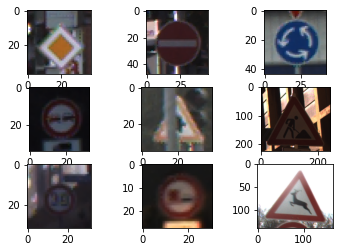

In [ ]:
for i in range(0,9):
    plt.subplot(331+i)
    seed=np.random.randint(0,39210)
    im = Image.open(train_imgpath[seed])  
    plt.imshow(im)
    
plt.show()

In [ ]:
train_data=[]
train_labels=[]
path = "/content/"
for i in range(len(train.Path)):
    image=cv2.imread(train_imgpath[i])
    image_from_array = Image.fromarray(image, 'RGB')
    size_image = image_from_array.resize((28,28))
    train_data.append(np.array(size_image))
    train_labels.append(train.ClassId[i])


X=np.array(train_data)
y=np.array(train_labels)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split( X, y, test_size=0.20, random_state=7777)

In [ ]:
#Spliting the images into train and validation sets

X_train = X_train.astype('float32')/255 
X_val = X_val.astype('float32')/255

#Using one hote encoding for the train and validation labels
from keras.utils import to_categorical
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam
from keras.layers import Dropout

In [ ]:
def create_model(layers):
    cnn = tf.keras.models.Sequential()
    cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[28, 28, 3]))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
    cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
    cnn.add(tf.keras.layers.Flatten())
    
    for i, nodes in enumerate(layers):
        cnn.add(tf.keras.layers.Dense(units=nodes, activation='relu'))
            
    cnn.add(tf.keras.layers.Dense(units=43, activation='softmax'))
    
    cnn.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return cnn

model = KerasClassifier(build_fn=create_model, verbose=1)
layers = [[128],(256, 128),(200, 150, 120)]
param_grid = dict(layers=layers)
grid = GridSearchCV(estimator=model, param_grid=param_grid, verbose=1)
grid_results = grid.fit(X_train,y_train, validation_data=(X_val, y_val))
print("Best: {0}, using {1}".format(grid_results.best_score_, grid_results.best_params_))
means = grid_results.cv_results_['mean_test_score']
stds = grid_results.cv_results_['std_test_score']
params = grid_results.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} ({1}) with: {2}'.format(mean, stdev, param))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


197/197 [==============================] - 0s 2ms/step - loss: 0.0217 - accuracy: 0.8119


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  1.3min finished


981/981 [==============================] - 4s 4ms/step - loss: 0.0408 - accuracy: 0.6530 - val_loss: 0.0135 - val_accuracy: 0.9018
Best: 0.8895017981529236, using {'layers': (256, 128)}
0.8482487678527832 (0.010644724586591986) with: {'layers': [128]}
0.8895017981529236 (0.008448039314396697) with: {'layers': (256, 128)}
0.8217872500419616 (0.008381570468903275) with: {'layers': (200, 150, 120)}


In [ ]:
def create_model2(dropout):
    # create model
    cnn = tf.keras.models.Sequential()
    cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[28, 28, 3]))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
    cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
    cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
    cnn.add(tf.keras.layers.Flatten())
    cnn.add(tf.keras.layers.Dense(units=256, activation='relu'))
    cnn.add(Dropout(dropout))
    cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))
    cnn.add(Dropout(dropout))
    cnn.add(tf.keras.layers.Dense(units=43, activation='softmax'))
    
    # compile the model
    cnn.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return cnn

# create the model
model = KerasClassifier(build_fn = create_model2, verbose = 1,epochs=10, batch_size=20)

# define the grid search parameters
dropout = [0.0, 0.1, 0.2]

# make a dictionary of the grid search parameters
param_grid = dict(dropout=dropout)

# build and fit the GridSearchCV
grid = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 1)
grid_results = grid.fit(X_train,y_train, validation_data=(X_val, y_val))

# summarize the results
print("Best: {0}, using {1}".format(grid_results.best_score_, grid_results.best_params_))
means = grid_results.cv_results_['mean_test_score']
stds = grid_results.cv_results_['std_test_score']
params = grid_results.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{0} ({1}) with: {2}'.format(mean, stdev, param))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Epoch 1/10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1255/1255 [==============================] - 5s 4ms/step - loss: 0.0408 - accuracy: 0.6465 - val_loss: 0.0135 - val_accuracy: 0.9072
Epoch 2/10
1255/1255 [==============================] - 5s 4ms/step - loss: 0.0084 - accuracy: 0.9379 - val_loss: 0.0058 - val_accuracy: 0.9594
Epoch 3/10
1255/1255 [==============================] - 5s 4ms/step - loss: 0.0046 - accuracy: 0.9686 - val_loss: 0.0054 - val_accuracy: 0.9624
Epoch 4/10
1255/1255 [==============================] - 5s 4ms/step - loss: 0.0026 - accuracy: 0.9828 - val_loss: 0.0035 - val_accuracy: 0.9759
Epoch 5/10
1255/1255 [==============================] - 5s 4ms/step - loss: 0.0022 - accuracy: 0.9853 - val_loss: 0.0058 - val_accuracy: 0.9644
Epoch 6/10
1255/1255 [==============================] - 4s 4ms/step - loss: 0.0018 - accuracy: 0.9873 - val_loss: 0.0063 - val_accuracy: 0.9638
Epoch 7/10
1255/1255 [==============================] - 4s 3ms/step - loss: 0.0014 - accuracy: 0.9907 - val_loss: 0.0031 - val_accuracy: 0.9791
Epo

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 12.5min finished


1569/1569 [==============================] - 6s 4ms/step - loss: 0.0452 - accuracy: 0.5974 - val_loss: 0.0103 - val_accuracy: 0.9194
Epoch 2/10
1569/1569 [==============================] - 6s 4ms/step - loss: 0.0093 - accuracy: 0.9276 - val_loss: 0.0049 - val_accuracy: 0.9656
Epoch 3/10
1569/1569 [==============================] - 6s 4ms/step - loss: 0.0048 - accuracy: 0.9638 - val_loss: 0.0025 - val_accuracy: 0.9853
Epoch 4/10
1569/1569 [==============================] - 6s 4ms/step - loss: 0.0036 - accuracy: 0.9743 - val_loss: 0.0022 - val_accuracy: 0.9852
Epoch 5/10
1569/1569 [==============================] - 6s 4ms/step - loss: 0.0026 - accuracy: 0.9812 - val_loss: 0.0021 - val_accuracy: 0.9865
Epoch 6/10
1569/1569 [==============================] - 6s 4ms/step - loss: 0.0023 - accuracy: 0.9826 - val_loss: 0.0016 - val_accuracy: 0.9911
Epoch 7/10
1569/1569 [==============================] - 6s 4ms/step - loss: 0.0018 - accuracy: 0.9872 - val_loss: 0.0019 - val_accuracy: 0.9883
Epo

In [ ]:
cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[28, 28, 3]))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(units=256, activation='relu'))
cnn.add(Dropout(0.2))
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))
cnn.add(Dropout(0.2))
cnn.add(tf.keras.layers.Dense(units=43, activation='softmax'))

# compile the model
cnn.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

history = cnn.fit(X_train, y_train, batch_size=20, epochs=20,validation_data=(X_val, y_val))

Epoch 1/20
1569/1569 [==============================] - 6s 4ms/step - loss: 0.0462 - accuracy: 0.5865 - val_loss: 0.0118 - val_accuracy: 0.9128
Epoch 2/20
1569/1569 [==============================] - 6s 4ms/step - loss: 0.0109 - accuracy: 0.9146 - val_loss: 0.0072 - val_accuracy: 0.9429
Epoch 3/20
1569/1569 [==============================] - 6s 4ms/step - loss: 0.0057 - accuracy: 0.9572 - val_loss: 0.0037 - val_accuracy: 0.9740
Epoch 4/20
1569/1569 [==============================] - 6s 4ms/step - loss: 0.0038 - accuracy: 0.9718 - val_loss: 0.0028 - val_accuracy: 0.9801
Epoch 5/20
1569/1569 [==============================] - 6s 4ms/step - loss: 0.0029 - accuracy: 0.9788 - val_loss: 0.0029 - val_accuracy: 0.9805
Epoch 6/20
1569/1569 [==============================] - 6s 4ms/step - loss: 0.0025 - accuracy: 0.9813 - val_loss: 0.0020 - val_accuracy: 0.9880
Epoch 7/20
1569/1569 [==============================] - 6s 4ms/step - loss: 0.0021 - accuracy: 0.9850 - val_loss: 0.0018 - val_accuracy:

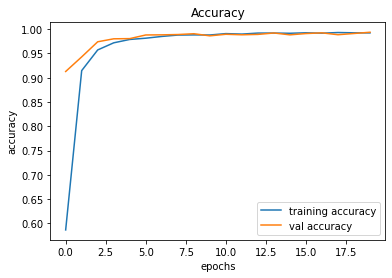

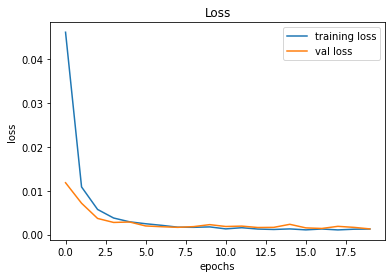

In [ ]:
import matplotlib.pyplot as plt

plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [ ]:
test=pd.read_csv('/content/Test.csv')
X_test=train['Path']
y_test=train.ClassId

In [ ]:
data_dir = "/content"
test_imgpath= list((data_dir + '/' + str(test.Path[i])) for i in range(len(test.Path)))

In [ ]:
test_data=[]
test_labels=[]


path = "/content/"
for i in range(len(test.Path)):
    image=cv2.imread(test_imgpath[i])
    image_from_array = Image.fromarray(image, 'RGB')
    size_image = image_from_array.resize((28,28))
    test_data.append(np.array(size_image))
    test_labels.append(test.ClassId[i])


X_test=np.array(test_data)
y_test=np.array(test_labels)

X_test = X_test.astype('float32')/255 

In [ ]:
pred = cnn.predict_classes(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, pred)

0.9541567695961995

In [ ]:
import pickle
print("[INFO] Saving model...")
pickle.dump(model,open('cnn_model.pkl', 'wb'))

[INFO] Saving model...
